In [ ]:
#cluster as string
#Precision on kmeans
#Kmeans++
#Number of clusters
#best model?
#Explain kmenas
#silhouette and elbow
#normalizar as variáveis para não dar peso maior para variáveis com valores mais altos
#como usar as categoricas no kmeans?

# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [2]:
#Name
ModelName = 'user_segmentation_model'

#Setting the VarId and VarDate parameters
VarId = 'id'
VarDate = 'ReferenceDate'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#ATTENTION: bucket name created in S3
bucket = 'now-app-media-service'


#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#It is necessary to define the types of variables (cageroric and numeric) to ensure that the type of data used in the modeling will be the most suitable.
#For example, categorical variables need to be defined as a string because this prevents it from being treated as a numeric variable in H20 modeling
#Another example is that the string variables will have a missing treatment by placing the missing category for all values found as 'null'
CAT = []

#float
NUM = ['relevanceScore'
       ,'age'
       ,'headlineWordCount'
       ,'postTextWordCount'
       ,'tagsWordCount']
selected_features = CAT + NUM

# 2. Import Libraries

In [3]:
try:
    import sys
    sys.path.append('/var/lang/lib/python37.zip')
    sys.path.append('/var/lang/lib/python3.7')
    sys.path.append('/var/lang/lib/python3.7/lib-dynload')
    sys.path.append('/var/lang/lib/python3.7/site-packages')
    sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')
except:
    pass

In [4]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import boto3
import awswrangler as wr
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [5]:
#Criar conexão com o Athena
my_boto3_session = boto3.Session(region_name='us-east-1')

In [6]:
query4="select * from nowapp.%s" % ModelName
dataprep_df_full = wr.athena.read_sql_query(query4, database="nowapp", boto3_session=my_boto3_session).rename(columns={
                   'likedrecommendation' : 'likedRecommendation',
                   'posttextwordcount' : 'postTextWordCount',
                   'relevancescore' : 'relevanceScore',
                   'tagswordcount' : 'tagsWordCount',
                   'headlinewordcount' : 'headlineWordCount',
                   'referencedate' : 'ReferenceDate'
                  })

In [7]:
dataprep_df_full.head()

,relevanceScore,age,headlineWordCount,postTextWordCount,tagsWordCount,id,ReferenceDate,partition_0
0,5.0,46.0,5.0,21.0,1.0,6e95327f-2f6e-4b5f-a928-a07d8299876d,2022-05,test_data
1,45.0,61.0,7.0,27.0,2.0,16d832f4-3122-4355-aae5-491f2bb416ed,2022-05,test_data
2,24.0,51.0,6.0,21.0,2.0,e6aa2ea9-8a67-454f-8875-130f4c47656f,2022-05,test_data
3,3.0,55.0,3.0,27.0,2.0,a57f2c48-8538-4902-ace7-ba5cdf4454af,2022-05,test_data
4,25.0,27.0,6.0,26.0,3.0,7209ac05-388b-43fe-9c33-351582330627,2022-05,test_data


In [8]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [9]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

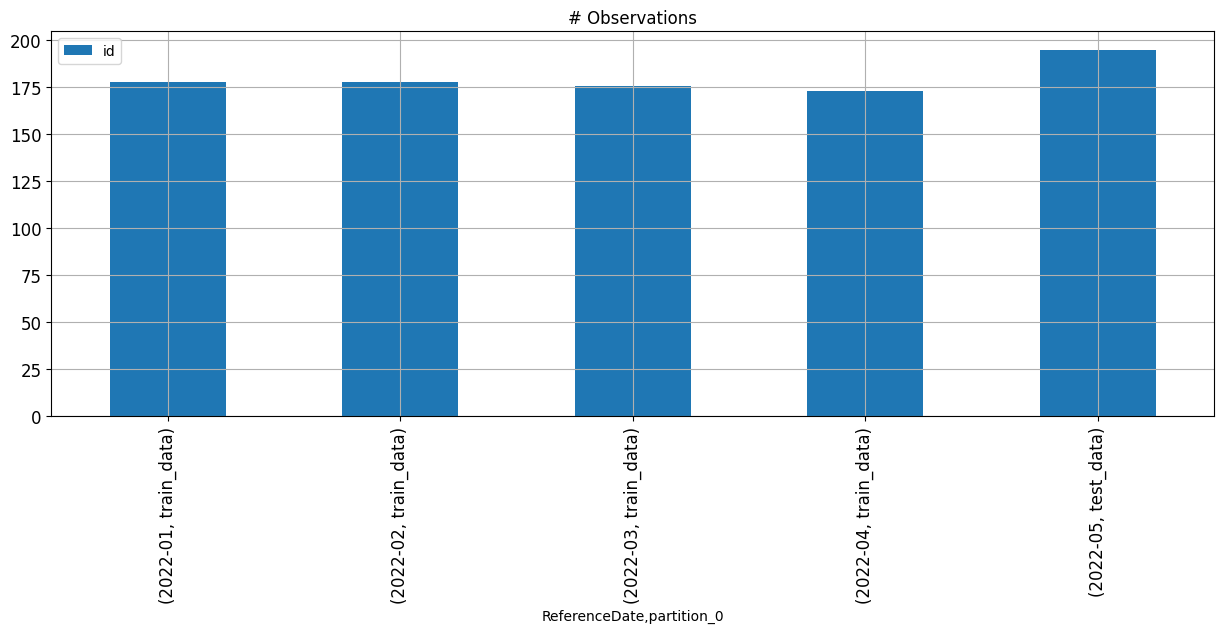

In [10]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, 'partition_0']].groupby(by=[VarDate, 'partition_0']).agg({VarId:'count'})
dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations"))

## 3.1 Treatment of Numeric Missing Data

In [11]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [12]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [13]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 Traning Models with H2O AutoML

## 4.1.1 Creating context and H2O and Importing data into the H2O context

In [15]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '4G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_342"; OpenJDK Runtime Environment Corretto-8.342.07.4 (build 1.8.0_342-b07); OpenJDK 64-Bit Server VM Corretto-8.342.07.4 (build 25.342-b07, mixed mode)
  Starting server from /var/lang/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpqcqkuq42
  JVM stdout: /tmp/tmpqcqkuq42/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpqcqkuq42/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,4 months and 8 days !!!
H2O_cluster_name:,H2O_from_python_unknownUser_c4ldpd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [16]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "train_data"').loc[:, (selected_features)])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 640
Validation: 65


In [17]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features)])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 195


## 4.2.2 Train the H2O Champion algorithm with new data

In [53]:
from h2o.estimators import H2OKMeansEstimator
# Build and train the model:
kmeans = H2OKMeansEstimator(k=10,
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1)
kmeans.train(x=selected_features,
                  training_frame=train_hdf,
                  validation_frame=valid_hdf)

# Eval performance:
perf = kmeans.model_performance()

#  Generate predictions on a validation set (if necessary):
valid_pred = kmeans.predict(valid_hdf)
valid_hdf = valid_hdf.cbind(valid_pred)
valid_hdf[VarTarget] = valid_hdf[VarTarget].asfactor()

train_pred = kmeans.predict(train_hdf)
train_hdf = train_hdf.cbind(train_pred)
train_hdf[VarTarget] = train_hdf[VarTarget].asfactor()

test_pred = kmeans.predict(test_hdf)
test_hdf = test_hdf.cbind(test_pred)
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


In [18]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='H2O_KMeans_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators import H2OKMeansEstimator
kmeans = H2OKMeansEstimator(k=10,
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1)

# The use of a validation_frame is recommended
kmeans.train(x=selected_features,
                  training_frame=train_hdf,
                  validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(kmeans)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:00.638431

Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1668687361081_1


Model Summary: 


,,number_of_rows,number_of_clusters,number_of_categorical_columns,number_of_iterations,within_cluster_sum_of_squares,total_sum_of_squares,between_cluster_sum_of_squares
0,,640.0,6.0,0.0,31.0,91032.128759,648632.1125,557599.983741




ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 91032.12875929932
Total Sum of Square Error to Grand Mean: 648632.1125000002
Between Cluster Sum of Square Error: 557599.9837407009

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,77.0,8847.506494
1,,2.0,101.0,14474.495050
2,,3.0,121.0,17583.702479
3,,4.0,79.0,10786.354430
4,,5.0,137.0,20206.934307
5,,6.0,125.0,19133.136000



ModelMetricsClustering: kmeans
** Reported on validation data. **

Total Within Cluster Sum of Square Error: 9345.005277299333
Total Sum of Square Error to Grand Mean: 53224.36923076923
Between Cluster Sum of Square Error: 43879.3639534699

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,6.0,541.531962
1,,2.0,10.0,1741.772767
2,,3.0,6.0,1019.089133
3,,4.0,10.0,1081.271591
4,,5.0,17.0,2546.205232
5,,6.0,16.0,2415.134592



Scoring History: 


,,timestamp,duration,iterations,number_of_clusters,number_of_reassigned_observations,within_cluster_sum_of_squares
0,,2022-11-17 12:16:29,0.054 sec,0.0,0.0,NaN,NaN
1,,2022-11-17 12:16:29,0.106 sec,1.0,1.0,640.0,1.028430e+06
2,,2022-11-17 12:16:29,0.120 sec,2.0,1.0,0.0,6.486321e+05
3,,2022-11-17 12:16:29,0.138 sec,3.0,2.0,0.0,2.789170e+05
4,,2022-11-17 12:16:29,0.148 sec,4.0,3.0,11.0,2.252280e+05
5,,2022-11-17 12:16:29,0.155 sec,5.0,3.0,4.0,2.246630e+05
6,,2022-11-17 12:16:29,0.159 sec,6.0,3.0,2.0,2.245439e+05
7,,2022-11-17 12:16:29,0.162 sec,7.0,3.0,0.0,2.245167e+05
8,,2022-11-17 12:16:29,0.177 sec,8.0,4.0,43.0,1.895685e+05
9,,2022-11-17 12:16:29,0.182 sec,9.0,4.0,33.0,1.835203e+05



See the whole table with table.as_data_frame()



In [19]:
perf = kmeans.model_performance()
perf


ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 91032.12875929932
Total Sum of Square Error to Grand Mean: 648632.1125000002
Between Cluster Sum of Square Error: 557599.9837407009

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,77.0,8847.506494
1,,2.0,101.0,14474.495050
2,,3.0,121.0,17583.702479
3,,4.0,79.0,10786.354430
4,,5.0,137.0,20206.934307
5,,6.0,125.0,19133.136000


In [20]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

In [21]:
h2o.save_model(model=kmeans, path='%s/models/candidates/' % OutputPath, force=True)

'/home/sagemaker-user/clevertech-NewsNow/clusters-segmentation/user-segmentation/output_model/models/candidates/KMeans_model_python_1668687361081_1'

# 5. Exporting the best model to Deploy (Usar o path_model_mojo para o código 3_Explaining_Model.ipynb)

In [22]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, kmeans.model_id))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    print(e)

path_model_mojo: /home/sagemaker-user/clevertech-NewsNow/clusters-segmentation/user-segmentation/output_model/models/best/KMeans_model_python_1668687361081_1.zip


In [51]:
#Confusion Matrix for the Champion
df_cluster_tmp = h2o.mojo_predict_pandas(dataprep_df.loc[:, (selected_features)], mojo_zip_path=path_model_mojo, verbose=False)

df_cluster = pd.concat([df_cluster_tmp.reset_index(drop=True), dataprep_df.loc[:, (selected_features+['partition_0'])].reset_index(drop=True)], axis=1)
# df_cluster['cluster'] = df_cluster['cluster'] + 1
df_cluster['cluster'] = df_cluster['cluster'].astype(int)

df_cluster

Detected 1 unused columns in the input data set: {}


,cluster,relevanceScore,age,headlineWordCount,postTextWordCount,tagsWordCount,partition_0
0,2,5.0,46.0,5.0,21.0,1.0,test_data
1,5,45.0,61.0,7.0,27.0,2.0,test_data
2,2,24.0,51.0,6.0,21.0,2.0,test_data
3,2,3.0,55.0,3.0,27.0,2.0,test_data
4,0,25.0,27.0,6.0,26.0,3.0,test_data
...,...,...,...,...,...,...,...
895,4,78.0,62.0,7.0,11.0,4.0,train_data
896,4,75.0,56.0,7.0,21.0,2.0,train_data
897,5,54.0,48.0,5.0,22.0,5.0,train_data
898,1,76.0,28.0,4.0,31.0,1.0,train_data


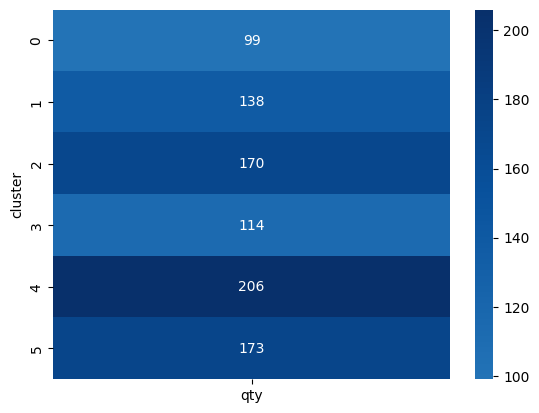

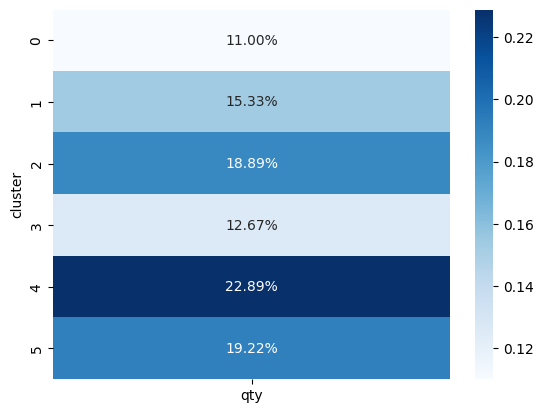

In [52]:
df_cluster_plot = df_cluster.reset_index().groupby(['cluster']).count()[['index']].rename(columns={'index': 'qty'})
sns.heatmap(df_cluster_plot, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_cluster_plot/np.sum(df_cluster_plot), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 6. Save final dataset with predictions into S3 to explain the model

In [53]:
csv_buffer = StringIO()
df_cluster.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/%s.csv' % (ModelName+'_scored', ModelName+'_scored')).put(Body=csv_buffer.getvalue())
del csv_buffer

In [54]:
#Include Glue delete table before start the crawler
glue = my_boto3_session.client('glue', region_name="us-east-1")

try:
    glue.delete_table(
        DatabaseName='nowapp',
        Name=ModelName+'_scored'
    )
except:
    print("OK: The table doesn't exist yet. It is not necessary to delete it.")

glue.update_crawler(Name='nowapp',
                    Targets={'S3Targets': [{'Path': 's3://%s/databases/%s' % (bucket, ModelName+'_scored'),
                               'Exclusions': []}]})

glue.start_crawler(Name='nowapp')

{'ResponseMetadata': {'RequestId': '2d5c480a-8c82-4753-b116-cbe5f6505c54',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 17 Nov 2022 20:00:53 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '2d5c480a-8c82-4753-b116-cbe5f6505c54'},
  'RetryAttempts': 0}}